
# Fundamental analysis of SP500 companies & Deep Learning classification of analysts' recommendations of these companies
## Note: Interactive Plotly figures wont show up when viewing at Github, but trust me, they're neat
## Import needed packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as pdr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from tqdm.notebook import tqdm
import yfinance as yf

# yf.pdr_override()


## Functions to get stock data and to plot share prices

In [2]:
def get_fundamentals(tickers):
    '''Gets the fundamentals data for given tickers and produces a clean dataframe from it'''
    
    tickers_data = {}
    # fundamentals = ['forwardPE',
    #                 'trailingPE',
    #                 'forwardEps',
    #                 'sector',
    #                 'fullTimeEmployees',
    #                 'country',
    #                 'twoHundredDayAverage',
    #                 'averageDailyVolume10Day',
    #                 'trailingPE',
    #                 'marketCap',
    #                 'priceToSalesTrailing12Months',
    #                 'trailingEps',
    #                 'priceToBook',
    #                 'earningsQuarterlyGrowth',
    #                 'pegRatio']
    filter_date = dt.datetime.today()-dt.timedelta(weeks=2)
    results_dict = {}
    # Loop all tickers and get some interesting fundamentals.
    # tickers = ["GOOGL","AMZN","FB"] #<- for testing before going for the 1 hour update of all sp500 tickers
    for ticker in tqdm(tickers):
        ticker_object = yf.Ticker(ticker)
        # print(ticker)
        # Get the recommendations
        tickers_recs_all = ticker_object.recommendations
        if tickers_recs_all is not None:
            latest_recs = tickers_recs_all.loc[tickers_recs_all.index>=filter_date,"To Grade"]
            if not latest_recs.empty:
                rec = latest_recs.mode()
                if len(rec.index) == 1:
                    results_dict[ticker] = rec.item()
                else:
                    results_dict[ticker] = rec.loc[0]


        #convert info() output from dictionary to dataframe
        # new_info = { key:value for (key,value) in ticker_object.info.items() if key in fundamentals}
        new_info = { key:value for (key,value) in ticker_object.info.items()}

        temp = pd.DataFrame.from_dict(new_info, orient="index")
        temp.reset_index(inplace=True)
        if len(temp.columns) == 2:
            temp.columns = ["Attribute", "Value"]
            # add (ticker, dataframe) to main dictionary
            tickers_data[ticker] = temp

    # Recommendation data into neat dataframe
    results_df = pd.DataFrame.from_dict(results_dict,orient="index").reset_index().rename(columns={"index":'Ticker',0:'recommendation'})

    # Info data into neat dataframe
    combined_data = pd.concat(tickers_data).reset_index().drop(columns="level_1").rename(columns={'level_0': 'Ticker'})
    combined_data = combined_data.pivot(index='Ticker', columns='Attribute', values='Value').reset_index()
    combined_data = combined_data.rename_axis(None, axis=1).infer_objects()
    # combined_data.dropna(inplace=True) # Drop if any fundamental is NA

    combined_data = combined_data.merge(results_df,how="left")
    return combined_data

In [3]:
def get_data(mode="test",update_csv=False):
    '''Fetches stock tickers and fundamentals data from Yahoo or csv'''
    if mode == "test":
        # Tickers for lighter computing
        tickers =['FB','AMZN', 'AAPL', 'NFLX', 'GOOGL', 'MSFT']
        fundamentals = get_fundamentals(tickers)
    elif mode == "all":
        #Get all tickers from csv, if no csv in directory -> scrape them from wikipedia
        SP500_fileName = "SP500_symbols.csv"
        if not os.path.isfile(SP500_fileName):
            tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
            tickers = tickers[0]["Symbol"]
            tickers.to_csv(SP500_fileName)
        else:
            tickers = pd.read_csv(SP500_fileName).drop(['Unnamed: 0'],axis=1).to_numpy().flatten()

        # Get all fundamentals from csv, if no csv in directory -> scrape them from yahoo
        fundamentals_fileName = "SP500_fundamentals.csv"
        if (not os.path.isfile(fundamentals_fileName)) or update_csv:
            fundamentals = get_fundamentals(tickers)
            fundamentals.to_csv(fundamentals_fileName)
        else:
            fundamentals = pd.read_csv(fundamentals_fileName).drop(['Unnamed: 0'],axis=1).rename(columns={'majority_recommendation':'recommendation'})
    else:
        print("Select mode")
        return 0

    return tickers,fundamentals[fundamentals["Ticker"] != "UDR"] # Remove UDR from data as a huge outlier


In [4]:
def monitor_stock(stockName,start_date = "2020-01-01"):
    '''Creates an interactive Plotly figure to monitor the share prices and volumes of given stocks'''

    start = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end = dt.datetime.now()
    stock_df = pdr.DataReader(stockName, 'yahoo', start, end)
    # stocks.describe()
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, 
               row_width=[0.2, 0.7])

    # Old, used when there are multiple stocks in the df
    # fig.add_trace(go.Candlestick(x = stock_df.index, 
    #                                                open = stock_df[('Open',    stockName)], 
    #                                                high = stock_df[('High',    stockName)], 
    #                                                low = stock_df[('Low',    stockName)], 
    #                                                close = stock_df[('Close',    stockName)],showlegend=False,name="Price"))


    fig.add_trace(go.Candlestick(x = stock_df.index, 
                                                   open = stock_df['Open'], 
                                                   high = stock_df['High'], 
                                                   low = stock_df['Low'], 
                                                   close = stock_df['Close'],showlegend=False,name="Price"))

    fig.update_xaxes(row=1, col=1,
        title_text = '',
        rangeslider_visible = False,
        rangeselector = dict(
            buttons = list([
                dict(count = 1, label = '1M', step = 'month', stepmode = 'backward'),
                dict(count = 6, label = '6M', step = 'month', stepmode = 'backward'),
                dict(count = 1, label = 'YTD', step = 'year', stepmode = 'todate'),
                dict(count = 1, label = '1Y', step = 'year', stepmode = 'backward'),
                dict(step = 'all')])))
    
    fig.add_trace(go.Bar(x = stock_df.index,
                        y=stock_df['Volume'],
                        showlegend=False,name="Volume",
                        marker=dict(color="rgba(0,0,0.8,0.66)")),row=2, col=1)

 
    
    fig.update_layout(
        width=1280,
        height=800,
        title = {
            'text': stockName +' STOCK MONITOR',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            plot_bgcolor =  "rgba(1,1,1,0.05)")
    
    fig.update_yaxes(title_text ='Close Price', tickprefix = '$',row=1,col=1)
    fig.update_yaxes(title_text = 'Volume',row=2,col=1)
    fig.show()

## Monitor one example stock

In [5]:
monitor_stock("GOOGL")

## Get fundamentals data for companies

In [6]:
# tickers,fundamentals = get_data("test")
tickers,fundamentals = get_data("all")
# fundamentals = pd.read_csv("SP500_fundamentals.csv").drop(['Unnamed: 0'],axis=1)
# fundamentals.columns
fundamentals


,Ticker,52WeekChange,SandP52WeekChange,address1,address2,algorithm,annualHoldingsTurnover,annualReportExpenseRatio,ask,askSize,...,underlyingSymbol,uuid,volume,volume24Hr,volumeAllCurrencies,website,yield,ytdReturn,zip,recommendation
0,A,0.744009,0.461652,5301 Stevens Creek Boulevard,NaN,NaN,NaN,NaN,130.63,800.0,...,NaN,NaN,826640.0,NaN,NaN,http://www.agilent.com,NaN,NaN,95051,NaN
1,AAL,1.308097,0.461652,1 Skyview Drive,NaN,NaN,NaN,NaN,21.16,1400.0,...,NaN,NaN,30020760.0,NaN,NaN,http://www.aa.com,NaN,NaN,76155,Market Perform
2,AAP,0.665649,0.461652,2635 East Millbrook Road,NaN,NaN,NaN,NaN,203.65,800.0,...,NaN,NaN,512706.0,NaN,NaN,http://www.advanceautoparts.com,NaN,NaN,27604,Outperform
3,AAPL,0.781691,0.461652,One Apple Park Way,NaN,NaN,NaN,NaN,127.35,800.0,...,NaN,NaN,109432169.0,NaN,NaN,http://www.apple.com,NaN,NaN,95014,Buy
4,ABBV,0.343329,0.461652,1 North Waukegan Road,NaN,NaN,NaN,NaN,113.71,1000.0,...,NaN,NaN,5678710.0,NaN,NaN,http://www.abbvie.com,NaN,NaN,60064-6400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,NaN,NaN,1441 Gardiner Lane,NaN,NaN,NaN,NaN,119.64,800.0,...,NaN,b8fcb647-8cfb-3592-a2bf-1d9e21aa2452,1305330.0,NaN,NaN,http://www.yum.com,NaN,NaN,40213,Neutral
501,ZBH,NaN,NaN,345 East Main Street,NaN,NaN,NaN,NaN,172.05,1800.0,...,NaN,2f40c775-c890-3bae-80b9-c66c639207f6,1594051.0,NaN,NaN,http://www.zimmerbiomet.com,NaN,NaN,46580,NaN
502,ZBRA,NaN,NaN,3 Overlook Point,NaN,NaN,NaN,NaN,467.12,1000.0,...,NaN,53165cfc-fc73-3828-9c77-43899ee16f76,477682.0,NaN,NaN,http://www.zebra.com,NaN,NaN,60069,Underweight
503,ZION,NaN,NaN,One South Main Street,NaN,NaN,NaN,NaN,56.94,900.0,...,NaN,687d0c8c-3762-3a32-b59e-6ee6e99f5d45,1585108.0,NaN,NaN,http://www.zionsbancorporation.com,NaN,NaN,84133-1109,NaN


# Fundamental analysis on the companies
We'll use the following key fundamental indicators:   
   
__Price-to-earnings ratio (P/E):__ This ratio compares the current sales price of a company's stock to its per-share earnings. This should be used in comparison to other stocks, and not as an absolute value.     
   
__Projected earnings growth (PEG):__ PEG anticipates the one-year earnings growth rate of the stock. General rule: <1 => undervalued or ok. PEG = P/E ratio is divided by expected earnings growth going forward. A ratio significantly above 1.0 indicates that the stock might be too expensive for its likely growth. You’ll spend a lot of money but probably won’t see much return. A ratio much below 1.0 can indicate that the stock is poised for real growth, with its price too low for the company’s likely performance.      
   
__Price-to-sales ratio (P/S):__ The price-to-sales ratio values a company's stock price as compared to its revenues. The Price to Sales ratio is simply: Price divided by Sales. If the Price to Sales ratio is 1, then you're paying \$1 for every \$1 of sales the company makes. The lower the Price the Sales ratio, the better.    
   
__Price-to-book ratio (P/B):__ This ratio, also known as the price-to-equity ratio, compares a stock's book value to its market value. You can arrive at it by dividing the stock's most recent closing price by last quarter's book value per share. Book value is the value of an asset, as it appears in the company's books. It's equal to the cost of each asset less cumulative depreciation. Looking at the P/B ratio of a stock can be beneficial from a value investing perspective if you’re trying to find the undervalued hidden gems of the market. When companies have a low price-to-book ratio, meaning they’re trading for less than their book value, it can mean that the market has underestimated what the company is worth.   
   
__Forward earnings per share (EPS):__ While earnings are a company’s revenue minus operation expenses, earnings per share are the earnings remaining for shareholders divided by the number of outstanding shares. If a company has high earnings per share, investors perceive them to be more profitable.   
   

In [7]:
funs_to_use = ['Ticker','forwardPE','pegRatio','forwardEps','priceToSalesTrailing12Months','priceToBook','recommendation']
funs = fundamentals[funs_to_use].dropna(axis=0)

# Categorise the recommendations to positive neutral and negative by hand
rec_map = {'Buy': 'positive',
 'Equal-Weight': 'neutral',
 'Hold': 'neutral',
 'In-Line': 'neutral',
 'Market Outperform': 'positive',
 'Market Perform': 'neutral',
 'Mixed': 'neutral',
 'Neutral': 'neutral',
 'Outperform': 'positive',
 'Overweight': 'positive',
 'Peer Perform': 'neutral',
 'Positive': 'positive',
 'Sector Perform': 'neutral',
 'Sector Weight': 'neutral',
 'Strong Buy': 'positive',
 'Underperform': 'negative',
 'Underweight': 'negative'}

funs["recommendation"] = funs["recommendation"].map(rec_map)
funs



,Ticker,forwardPE,pegRatio,forwardEps,priceToSalesTrailing12Months,priceToBook,recommendation
2,AAP,17.488852,1.61,11.66,1.316802,3.770780,positive
3,AAPL,23.985876,1.46,5.31,6.531582,30.719970,positive
7,ABT,21.587801,1.49,5.41,5.541191,6.309903,positive
9,ADBE,35.781822,2.48,13.67,17.088709,17.296234,positive
11,ADM,14.806378,1.79,4.39,0.531879,1.743422,positive
...,...,...,...,...,...,...,...
486,WM,25.873394,2.13,5.45,3.815405,8.013753,positive
489,WRB,18.015625,0.75,4.48,1.769379,2.274226,neutral
493,WY,29.059258,2.62,1.35,3.536908,3.148980,positive
495,XEL,22.662458,3.76,3.17,3.154764,2.629575,positive


## Box plots of the chosen fundamentals

In [8]:
def plot_boxes(data):
   fig = px.box(data.melt(id_vars=["Ticker"]),
   y="value",
   facet_col="variable",
      color="variable",
      boxmode="overlay",
      hover_name="Ticker")

   fig.update_layout(width=1280,
                     height=600,
                     showlegend=False)
   fig.update_yaxes(matches=None,showticklabels=True)
   fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
   fig.show()


In [9]:
plot_boxes(funs)

In [10]:
funs["recommendation"].value_counts()/len(funs.index)

positive    0.655172
neutral     0.325123
negative    0.019704
Name: recommendation, dtype: float64

Only 0.15\% of the observations have negative recommendations. There's also a few outliers in the data that weäll remove for now

In [11]:
def remove_outliers(data,q=0.999):
    '''Removes huge outliers that do not belong in the 99.9 percentile'''

    for column in data.columns:
        if not isinstance(data[column].iloc[0],str):
            q_hi = data[column].quantile(q)
            q_low = data[column].quantile(1-q)

            data = data[(data[column]<q_hi) & (data[column] > q_low)]
    return data

In [12]:
funs = remove_outliers(funs)
plot_boxes(funs)


The current forward P/E of the whole SP500 list of companies is around USD 29 (May 2021), which is probably slightly inflated due to the current pandemic. We'll see what companies have their P/E ratio under USD 20, as they could be considered "cheaper" than the market. The PEG ratio being significantly under 1 is a sign of its price being too low for the company’s likely performance in the future.
   
Using these information, we can filter some promising companies from the SP500 list. We can then afterward visualise these companies using their respective values for EPS, P/S and P/B.


In [13]:
PE_filter = 20
peg_filter = 1
funs_filtered = funs.query('forwardPE <= @PE_filter & pegRatio <= @peg_filter')

fig = px.scatter(funs_filtered, x="forwardEps", y="priceToBook",
                 size='priceToSalesTrailing12Months', hover_name='Ticker',hover_data=['forwardPE','pegRatio'])
fig.update_layout(
        width=1280,
        height=800,
        title = {
            'text': f'SP500 companies with forwardPE <= {PE_filter} & pegRatio <= {peg_filter}',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

fig.add_annotation(
  x=30,  # arrows' head
  y=5,  # arrows' head
  ax=15,  # arrows' tail
  ay=20,  # arrows' tail
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='High EPS and low P/B could indicate promising companies',
  showarrow=True,
  arrowhead=3,
  arrowsize=4,
  arrowwidth=1,
  arrowcolor='black'
)
fig.show()

### Scatter pairs plot of all variables

In [14]:
fig = px.scatter_matrix(funs,
    dimensions=[x for x in funs_to_use if x not in ["Ticker","recommendation"]],
    color="recommendation")

fig.update_layout(
        width=1280,
        height=800,
        title = {
            'text': 'Pairs plot of each variable',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
fig.show()

In [15]:
# More analysis here; try to get WACC, DCF or FCF

## Perform PCA

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

## Correlation matrix of fundamentals

In [17]:
funs.corr()

,forwardPE,pegRatio,forwardEps,priceToSalesTrailing12Months,priceToBook
forwardPE,1.000000,0.001146,-0.063094,0.544339,0.136225
pegRatio,0.001146,1.000000,0.026261,0.125307,0.135966
forwardEps,-0.063094,0.026261,1.000000,0.011126,0.081353
priceToSalesTrailing12Months,0.544339,0.125307,0.011126,1.000000,0.260341
priceToBook,0.136225,0.135966,0.081353,0.260341,1.000000


# PCA

In [18]:
def pca_on_fundamentals(data):
    '''Performs PCA on the numeric values of the fundamentals dataset'''
    features = data.select_dtypes(include=np.number).columns.tolist()
    x = data.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    pd.DataFrame(data = x, columns = features).head()
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    # print("Explained variance ratios: ",pca.explained_variance_ratio_)
    return principalDf

def plot_pca(data):
    '''Plots the PCA onto two dimensions using interactive Plotly scatterplot'''
    principalDf = pca_on_fundamentals(data)

    fig = px.scatter(principalDf,
    x="PC1",
    y="PC2",
    color=data["recommendation"])

    fig.update_layout(
        width=1280,
        height=800,
        title = {
            'text': 'Scatter plot of the principal components',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.show()

In [19]:
# pca = pca_on_fundamentals(fundamentals)
plot_pca(funs)

PCA's first two dimensions explain roughly 55% of the variation in the data. We should look if we could use Tensorflow to analyse the data, as the data could have highly nonlinear and complex structure. There is also a huge imbalance between the different recommendations, as only 3 of the hundreds of observations have a negative recommendation.

# Tensorflow
## Create a classification tool with Tensorflow and try to classify companies to the categories given by "professional" analysts
### Also, switch to Seaborn for plotting

In [20]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tempfile

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

mpl.rcParams['figure.figsize'] = (16, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Get analysts' recommendations and give each stock a class label using "majority-rule" on the recommendations. The recommendations are from the last two weeks compared to the fundamental data, and they should reflect the current fundamental data in the csv.

In [21]:

df_tensorflow_full = funs.copy()
df_tensorflow_full

,Ticker,forwardPE,pegRatio,forwardEps,priceToSalesTrailing12Months,priceToBook,recommendation
2,AAP,17.488852,1.61,11.66,1.316802,3.770780,positive
3,AAPL,23.985876,1.46,5.31,6.531582,30.719970,positive
7,ABT,21.587801,1.49,5.41,5.541191,6.309903,positive
9,ADBE,35.781822,2.48,13.67,17.088709,17.296234,positive
11,ADM,14.806378,1.79,4.39,0.531879,1.743422,positive
...,...,...,...,...,...,...,...
486,WM,25.873394,2.13,5.45,3.815405,8.013753,positive
489,WRB,18.015625,0.75,4.48,1.769379,2.274226,neutral
493,WY,29.059258,2.62,1.35,3.536908,3.148980,positive
495,XEL,22.662458,3.76,3.17,3.154764,2.629575,positive


### Preprocess data

In [22]:
df = remove_outliers(df_tensorflow_full).drop(columns="Ticker")
df['recommendation'] = pd.factorize(df['recommendation'])[0]
df.describe()



,forwardPE,pegRatio,forwardEps,priceToSalesTrailing12Months,priceToBook,recommendation
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,23.848935,2.063934,8.089836,5.308941,8.768500,0.360656
std,14.349453,2.432704,7.457804,4.636370,10.765955,0.514604
min,7.801647,-10.050000,0.320000,0.540820,0.843112,0.000000
25%,14.813126,1.240000,3.485000,2.063410,2.410704,0.000000
50%,19.948597,2.010000,6.420000,3.860293,4.895294,0.000000
75%,27.493963,2.920000,10.400000,6.948910,11.461070,1.000000
max,109.340910,8.980000,70.930000,25.186770,87.702090,2.000000


Create the train, validation and test sets from the data

In [23]:

train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('recommendation'))
val_labels = np.array(val_df.pop('recommendation'))
test_labels = np.array(test_df.pop('recommendation'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalise the data

In [24]:

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# train_features = np.clip(train_features, -5, 5)
# val_features = np.clip(val_features, -5, 5)
# test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (116,)
Validation labels shape: (30,)
Test labels shape: (37,)
Training features shape: (116, 5)
Validation features shape: (30, 5)
Test features shape: (37, 5)


### Train the model
This is just to test that tensorflow is working accordingly. I need to read more about the type of layers we should use here. Also need to see how to combat the imbalance of the data; should we try to find more observations or can we cope using some algorithmic techniques?

In [25]:

model = keras.Sequential(
    [
        keras.layers.Dense(20, input_dim=train_features.shape[1],activation="relu",kernel_initializer='he_uniform'),
        keras.layers.Dense(3,activation="softmax"),
    ]
)

model.compile(loss="sparse_categorical_crossentropy", optimizer= "adam", metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________


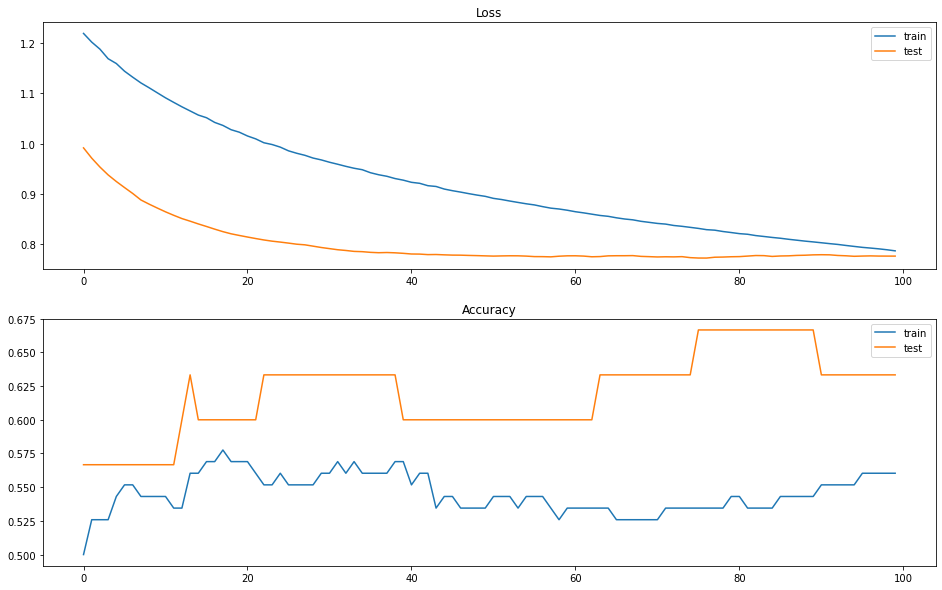

In [26]:
class_weights = dict(zip(np.unique(train_labels),
                    class_weight.compute_class_weight(class_weight="balanced",
                    classes = np.unique(train_labels),
                    y=train_labels)))
history = model.fit(train_features,
                    train_labels,
                    validation_data=(val_features, val_labels),
                    class_weight = class_weights,
                    epochs=100,
                    verbose=0
                    )

plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.show()


### Test the model

In [27]:
test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 0.9935 - sparse_categorical_accuracy: 0.3784

Test accuracy: 0.37837839126586914


In [28]:
test_predictions = model.predict(test_features)

In [29]:
def plot_confusion(labels, predictions):
  cm = confusion_matrix(labels, predictions.argmax(1))
  plt.figure()
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix - argmax from predicted classes')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

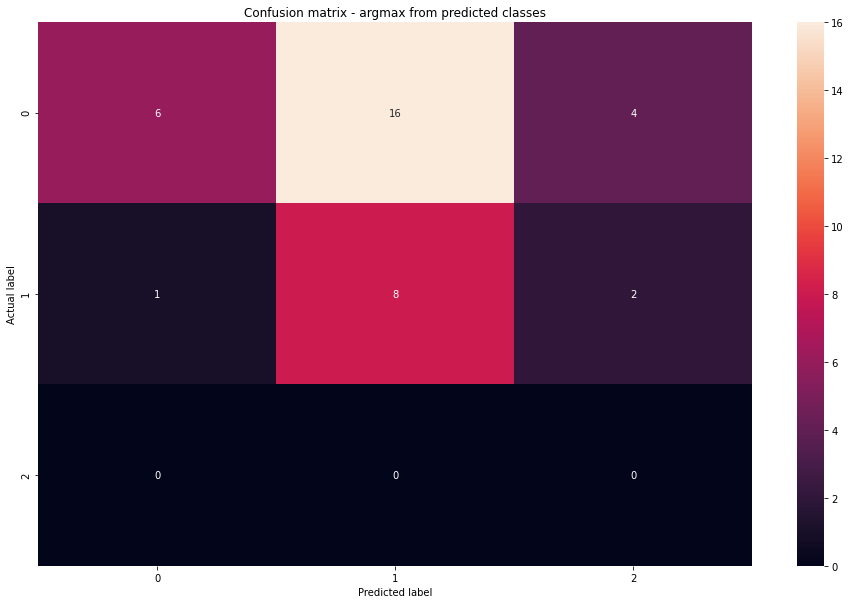

In [30]:
plot_confusion(test_labels, test_predictions)